In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
df_train = pd.read_pickle('../features/train_clean.pkl')
df_test = pd.read_pickle('../features/test_clean.pkl')
df_train["oof"] = 0
TARGET = "open_channels"
df_test[TARGET] = 0
df_test["group"] = df_test["batch"].astype("str") + "_" + df_test["mini_batch"].astype("str")
print(df_train.shape, df_test.shape)
df_test.head()

(4500000, 7) (2000000, 8)


,time,signal,local_time,mini_local_time,batch,mini_batch,open_channels,group
0,500.000092,-2.649832,0.000092,0.000092,1,1,0,1_1
1,500.000214,-2.849463,0.000214,0.000214,1,1,0,1_1
2,500.000305,-2.860094,0.000305,0.000305,1,1,0,1_1
3,500.000397,-2.435126,0.000397,0.000397,1,1,0,1_1
4,500.000488,-2.615657,0.000488,0.000488,1,1,0,1_1


In [3]:
# oof
oof_model_1 = np.load("hmm_oof/train_nn_oof_model1.npy")
oof_model_2 = np.load("hmm_oof/train_nn_oof_model2.npy")
oof_model_3 = np.load("hmm_oof/train_nn_oof_model3.npy")
oof_model_4 = np.load("hmm_oof/train_nn_oof_model4.npy")
oof_model_5 = np.load("hmm_oof/train_nn_oof_model5.npy")

df_train.loc[df_train.batch.isin([1,2]), "oof"] = oof_model_1
df_train.loc[df_train.batch.isin([3,7]), "oof"] = oof_model_2
df_train.loc[df_train.batch.isin([4]), "oof"] = oof_model_3
df_train.loc[df_train.batch.isin([6,9]), "oof"] = oof_model_4
df_train.loc[df_train.batch.isin([5,10]), "oof"] = oof_model_5

print("oof score is:", f1_score(df_train.open_channels, df_train.oof, average = 'macro').round(4))

oof score is: 0.9424


In [4]:
# pred
pred_model_1 = np.load("hmm_pred/test_nn_oof_model1.npy")
pred_model_2 = np.load("hmm_pred/test_nn_oof_model2.npy")
pred_model_3 = np.load("hmm_pred/test_nn_oof_model3.npy")
pred_model_4 = np.load("hmm_pred/test_nn_oof_model4.npy")
pred_model_5 = np.load("hmm_pred/test_nn_oof_model5.npy")

model_1_group = ["1_1", "1_4", "2_4", "3_1", "3_2", "3_3", "3_4", "3_5", "4_1", "4_2", "4_3", "4_4", "4_5"]
model_2_group = ["1_5"]
model_3_group = ["1_2", "2_5"]
model_4_group = ["1_3", "2_2"]
model_5_group = ["2_1", "2_3"]

df_test.loc[df_test.group.isin(model_1_group) , "open_channels"] = pred_model_1
df_test.loc[df_test.group.isin(model_2_group) , "open_channels"] = pred_model_2
df_test.loc[df_test.group.isin(model_3_group) , "open_channels"] = pred_model_3
df_test.loc[df_test.group.isin(model_4_group) , "open_channels"] = pred_model_4
df_test.loc[df_test.group.isin(model_5_group) , "open_channels"] = pred_model_5

In [5]:
ref = pd.read_csv('../submissions/submission_wavenet_rfc.csv',
                  dtype={'time': np.float32})
df_test["ref"] = ref["open_channels"]

df_test.loc[df_test.group.isin([
    "1_4", "2_4", "3_1", "3_2", "3_3", "3_4", "3_5", "4_1", "4_2", "4_3",
    "4_4", "4_5"
]) & (df_test.ref > 1), "open_channels"] = df_test[df_test.group.isin([
    "1_4", "2_4", "3_1", "3_2", "3_3", "3_4", "3_5", "4_1", "4_2", "4_3",
    "4_4", "4_5"
]) & (df_test.ref > 1)].ref.values

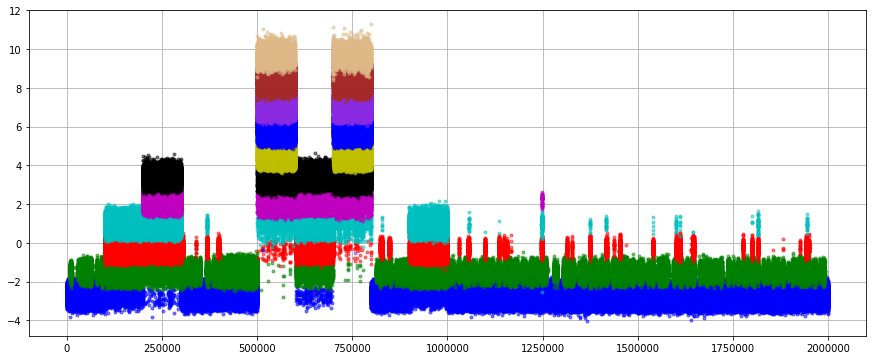

In [6]:
# visualize final predictions
color_list = [
    "b", "g", "r", "c", "m", "k", "y", '#0000FF', '#8A2BE2', '#A52A2A',
    '#DEB887', '#5F9EA0'
]
df_test.loc[(df_test.batch.isin([2])) & (df_test.mini_batch.isin([1, 3])), "signal"] += 2.73

fig = plt.figure(figsize=(15, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_test[df_test.open_channels == channel_i].signal,
             ".",
             color=color_list[channel_i],
             alpha=0.5)

In [7]:
sub  = pd.read_csv('../input/sample_submission.csv', dtype={'time': np.float32})
sub["open_channels"] = df_test.open_channels.astype(int)
# sub.to_csv('../submissions/sub.csv', index=False, float_format='%.4f')